Kathryn Mawhinney   
Dr. McCarthy    
Research in Health Economics    
April 23, 2025   

<h1 style="text-align: center;"><strong>Homework 5-1</strong></h1>

In this assignment, you’ll recreate the Insurance and Medicaid Expansion data and answer a few questions along the way. As with the prior assignments, the first step is to make sure you have the Insurance Access repository and downloaded all of the raw data sources. Once you have the data downloaded and the code running, answer the following questions.

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS

final_data = pd.read_csv('/Users/kathrynmawhinney/Documents/GitHub/Homework5/data/output/final_data.csv')

### Summarize the Data

1. Plot the share of the adult population with direct purchase health insurance over time.

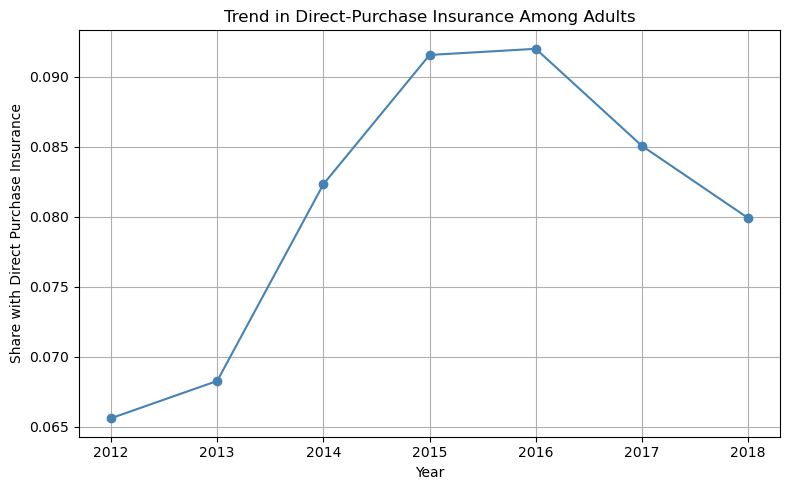

In [77]:
final_data['share_direct'] = final_data['ins_direct'] / final_data['adult_pop']
trend = final_data.groupby('year', as_index=False)['share_direct'].mean()

plt.figure(figsize=(8, 5))
plt.plot(trend['year'], trend['share_direct'], marker='o', linestyle='-', color='steelblue')
plt.title("Trend in Direct-Purchase Insurance Among Adults")
plt.xlabel("Year")
plt.ylabel("Share with Direct Purchase Insurance")
plt.grid(True)
plt.tight_layout()
plt.show()

2. Discuss the reduction in direct purchase health insurance in later years. Can you list a couple of policies that might have affected the success of the direct purchase insurance market?

In later years, the share of adults with direct-purchase health insurance declined. This reduction likely reflects decreased affordability, market instability, and reduced incentives to buy plans individually.
A couple of key policy changes that likely contributed to this trend include:
Repeal of the Individual Mandate (2019): The penalty for not having health insurance was reduced to $0 under the Tax Cuts and Jobs Act, removing a major incentive to buy coverage individually.
Expansion of Short-Term Plans: The Trump administration expanded access to short-term, limited-duration insurance plans, which are cheaper but offer fewer protections. These may have diverted healthier individuals away from ACA-compliant direct-purchase plans, increasing risk pools and premiums.

3. Plot the share of the adult population with Medicaid over time.

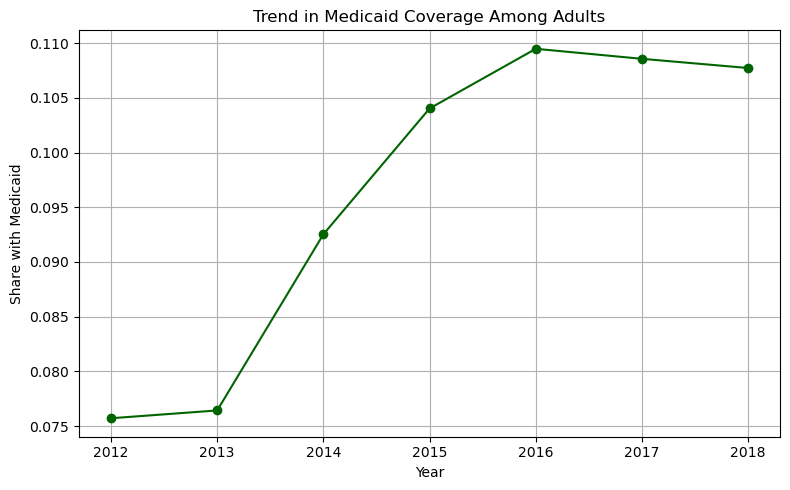

In [96]:
final_data['share_medicaid'] = final_data['ins_medicaid'] / final_data['adult_pop']
medicaid_trend = final_data.groupby('year', as_index=False)['share_medicaid'].mean()

plt.figure(figsize=(8, 5))
plt.plot(medicaid_trend['year'], medicaid_trend['share_medicaid'], marker='o', linestyle='-', color='darkgreen')
plt.title("Trend in Medicaid Coverage Among Adults")
plt.xlabel("Year")
plt.ylabel("Share with Medicaid")
plt.grid(True)
plt.tight_layout()
plt.show()

4. Plot the share of uninsured over time, separately by states that expanded Medicaid in 2014 versus those that did not. Drop all states that expanded after 2014.

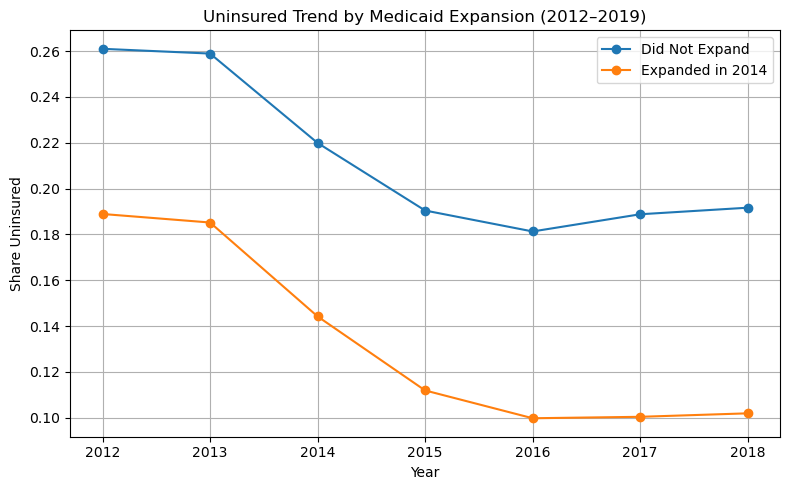

In [107]:
expansion_2014_states = final_data[final_data['expand_year'] == 2014]['State'].unique()
never_expanded_states = final_data[final_data['expand_ever'] == False]['State'].unique()
keep_states = list(set(expansion_2014_states).union(set(never_expanded_states)))

filtered_df = final_data[final_data['State'].isin(keep_states)].copy()
filtered_df['expansion_group'] = filtered_df['State'].apply(
    lambda x: 'Expanded in 2014' if x in expansion_2014_states else 'Did Not Expand'
)

uninsured_trend = (
    filtered_df.groupby(['year', 'expansion_group'])['uninsured']
    .sum()
    .div(filtered_df.groupby(['year', 'expansion_group'])['adult_pop'].sum())
    .reset_index(name='share_uninsured')
)

plt.figure(figsize=(8, 5))
for label, grp in uninsured_trend.groupby('expansion_group'):
    plt.plot(grp['year'], grp['share_uninsured'], marker='o', label=label)

plt.title("Uninsured Trend by Medicaid Expansion (2012–2019)")
plt.xlabel("Year")
plt.ylabel("Share Uninsured")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Estimate ATEs

For the rest of the assignment, we’re going to apply the difference-in-differences estimator to the question of Medicaid expansion and uninsurance.

5. Calculate the average percent of uninsured individuals in 2012 and 2015, separately for expansion and non-expansion states. Present your results in a basic 2x2 DD table.

In [116]:
df_dd = final_data[final_data['year'].isin([2012, 2015])].copy()
expansion_2014_states = final_data[final_data['expand_year'] == 2014]['State'].unique()
never_expanded_states = final_data[final_data['expand_ever'] == False]['State'].unique()
keep_states = list(set(expansion_2014_states).union(set(never_expanded_states)))

df_dd = df_dd[df_dd['State'].isin(keep_states)].copy()
df_dd['group'] = df_dd['State'].apply(
    lambda x: 'Expanded' if x in expansion_2014_states else 'Not Expanded'
)

ate_table = (
    df_dd.groupby(['group', 'year'])[['uninsured', 'adult_pop']]
    .sum()
    .reset_index()
)
ate_table['uninsured_rate'] = ate_table['uninsured'] / ate_table['adult_pop']

dd_pivot = ate_table.pivot(index='group', columns='year', values='uninsured_rate')
dd_pivot['Change'] = dd_pivot[2015] - dd_pivot[2012]
did_estimate = dd_pivot.loc['Expanded', 'Change'] - dd_pivot.loc['Not Expanded', 'Change']

print("\nQ5: Difference-in-Differences Table (Uninsurance Rates)")
print(dd_pivot.round(4))
print(f"\nEstimated ATE (Difference-in-Differences): {did_estimate:.4f}")


Q5: Difference-in-Differences Table (Uninsurance Rates)
year            2012    2015  Change
group                               
Expanded      0.1889  0.1119 -0.0770
Not Expanded  0.2610  0.1904 -0.0706

Estimated ATE (Difference-in-Differences): -0.0064


6. Estimate the effect of Medicaid expansion on the uninsurance rate using a standard DD regression estimator, again focusing only on states that expanded in 2014 versus those that never expanded.

In [123]:
df_reg_all_years = final_data[final_data['State'].isin(keep_states)].copy()
df_reg_all_years['treatment'] = df_reg_all_years['State'].apply(lambda x: 1 if x in expansion_2014_states else 0)
df_reg_all_years['post'] = df_reg_all_years['year'].apply(lambda x: 1 if x >= 2014 else 0)
df_reg_all_years['interaction'] = df_reg_all_years['treatment'] * df_reg_all_years['post']
df_reg_all_years['uninsured_rate'] = df_reg_all_years['uninsured'] / df_reg_all_years['adult_pop']

model = smf.ols('uninsured_rate ~ treatment + post + interaction', data=df_reg_all_years).fit()
print(model.summary())
print(f"\nEstimated ATE (DiD Regression across all years): {model.params['interaction']:.4f}")


                            OLS Regression Results                            
Dep. Variable:         uninsured_rate   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     73.07
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           1.24e-36
Time:                        17:36:06   Log-Likelihood:                 591.67
No. Observations:                 350   AIC:                            -1175.
Df Residuals:                     346   BIC:                            -1160.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2255      0.011     21.311      

7. Include state and year fixed effects in your estimates. Try using the lfe or fixest package to estimate this instead of directly including the fixed effects.

In [126]:
fe_df = final_data[final_data['State'].isin(keep_states)].copy()
fe_df['treatment'] = fe_df['State'].isin(expansion_2014_states).astype(int)
fe_df['post'] = (fe_df['year'] >= 2014).astype(int)
fe_df['interaction'] = fe_df['treatment'] * fe_df['post']
fe_df['uninsured_rate'] = fe_df['uninsured'] / fe_df['adult_pop']
fe_df = fe_df.set_index(['State', 'year'])

model_fe = PanelOLS.from_formula(
    formula="uninsured_rate ~ interaction + EntityEffects + TimeEffects",
    data=fe_df
).fit()

print("\nQ7: DiD Regression with State and Year Fixed Effects")
print(model_fe.summary)

ate_fe = model_fe.params['interaction']
print(f"\nEstimated ATE (w/ FE, all years): {ate_fe:.4f}")



Q7: DiD Regression with State and Year Fixed Effects
                          PanelOLS Estimation Summary                           
Dep. Variable:         uninsured_rate   R-squared:                        0.0134
Estimator:                   PanelOLS   R-squared (Between):             -0.0662
No. Observations:                 350   R-squared (Within):               0.1597
Date:                Mon, Apr 21 2025   R-squared (Overall):             -0.0546
Time:                        17:36:35   Log-likelihood                    1004.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3.9892
Entities:                          50   P-value                           0.0467
Avg Obs:                       7.0000   Distribution:                   F(1,293)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (ro

8. Repeat the analysis in question 7 but include all states (even those that expanded after 2014). Are your results different? If so, why?

In [132]:
df_all = final_data.copy()
df_all['treatment'] = df_all['expand_ever'].fillna(False).astype(int)
df_all['post'] = (df_all['year'] >= df_all['expand_year']).astype(int)
df_all['interaction'] = df_all['treatment'] * df_all['post']
df_all['uninsured_rate'] = df_all['uninsured'] / df_all['adult_pop']
df_all = df_all.set_index(['State', 'year'])

model_all = PanelOLS.from_formula(
    formula='uninsured_rate ~ interaction + EntityEffects + TimeEffects',
    data=df_all
).fit()

print("\nQ8: DiD Regression with All States and Years Included (w/ FE)")
print(model_all.summary)
print(f"\nEstimated ATE (All States, w/ FE): {model_all.params['interaction']:.4f}")


Q8: DiD Regression with All States and Years Included (w/ FE)
                          PanelOLS Estimation Summary                           
Dep. Variable:         uninsured_rate   R-squared:                        0.0206
Estimator:                   PanelOLS   R-squared (Between):             -0.0767
No. Observations:                 350   R-squared (Within):               0.1843
Date:                Mon, Apr 21 2025   R-squared (Overall):             -0.0633
Time:                        17:41:14   Log-likelihood                    1005.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.1670
Entities:                          50   P-value                           0.0136
Avg Obs:                       7.0000   Distribution:                   F(1,293)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-stat

/var/folders/8p/wmnjrdd55rx2pn76f5j7m2tw0000gn/T/ipykernel_20776/857791235.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all['treatment'] = df_all['expand_ever'].fillna(False).astype(int)


Including all states weakens the estimate because late expanders weren’t actually treated by 2015, diluting the treatment effect.

9. Provide an “event study” graph showing the effects of Medicaid expansion in each year. Use the specification that includes state and year fixed effects, limited to states that expanded in 2014 or never expanded.

/var/folders/8p/wmnjrdd55rx2pn76f5j7m2tw0000gn/T/ipykernel_20776/3032532614.py:18: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

event_m3

  event_model = PanelOLS.from_formula(formula, data=event_df, check_rank=False, drop_absorbed=True).fit()


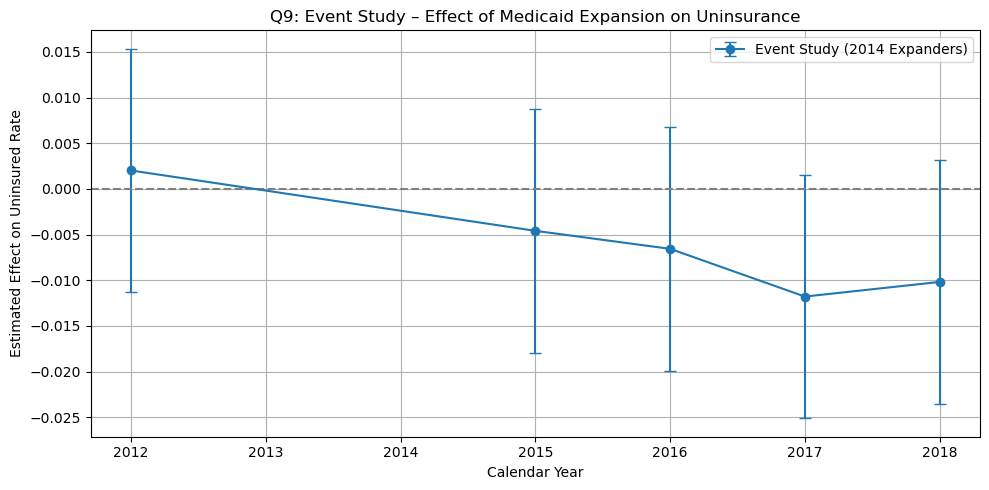

In [133]:
event_df = final_data[final_data['State'].isin(keep_states)].copy()
event_df = event_df.sort_values(['State', 'year'])
event_df['event_time'] = event_df['year'] - event_df['expand_year']
event_df.loc[event_df['expand_year'].isna(), 'event_time'] = -99  # never expanded

for t in range(-3, 5):
    if t == 0:
        continue
    col = f'event_m{abs(t)}' if t < 0 else f'event_p{t}'
    event_df[col] = (event_df['event_time'] == t).astype(int)

event_cols = [col for col in event_df.columns if col.startswith('event_') and col not in ['event_time', 'event_m1']]
event_df['uninsured_rate'] = event_df['uninsured'] / event_df['adult_pop']
event_df = event_df.set_index(['State', 'year'])

event_terms = ' + '.join(event_cols)
formula = f'uninsured_rate ~ {event_terms} + EntityEffects + TimeEffects'
event_model = PanelOLS.from_formula(formula, data=event_df, check_rank=False, drop_absorbed=True).fit()
coefs = event_model.params.filter(like='event_')
errors = event_model.std_errors[coefs.index]

def convert_event_name(name):
    suffix = name.split('_')[1]
    return -int(suffix[1:]) if suffix.startswith('m') else int(suffix[1:])

years = [2014 + convert_event_name(name) for name in coefs.index]

coefs = coefs.clip(lower=-0.2, upper=0.2)
errors = errors.clip(upper=0.2)

plt.figure(figsize=(10, 5))
plt.errorbar(years, coefs, yerr=1.96 * errors, fmt='o-', capsize=4, label='Event Study (2014 Expanders)')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Q9: Event Study – Effect of Medicaid Expansion on Uninsurance")
plt.xlabel("Calendar Year")
plt.ylabel("Estimated Effect on Uninsured Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

10. Repeat part 9 but again include states that expanded after 2014. Note: this is tricky…you need to put all states onto “event time” to create this graph.

/var/folders/8p/wmnjrdd55rx2pn76f5j7m2tw0000gn/T/ipykernel_20776/1071218890.py:18: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

event_m3

  event_model_q10 = PanelOLS.from_formula(formula_q10, data=event_df_q10, check_rank=False, drop_absorbed=True).fit()


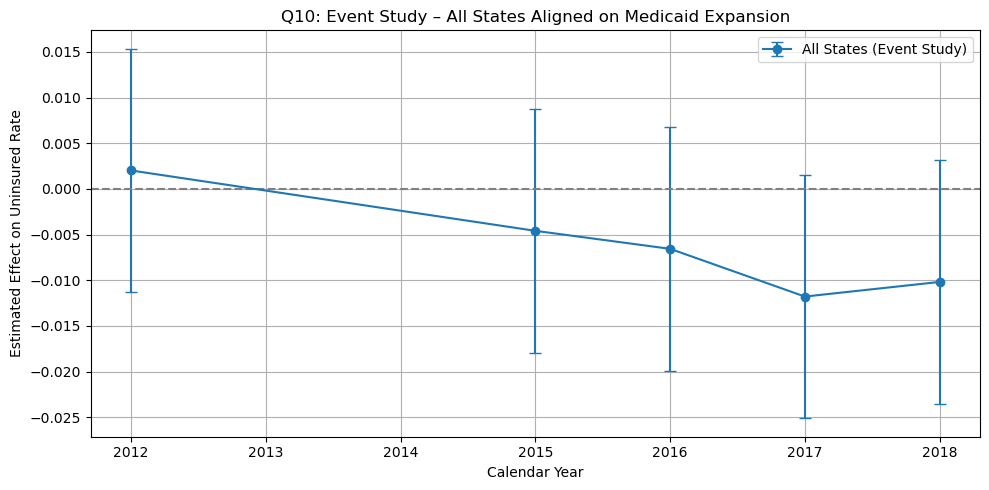

In [134]:
event_df_q10 = final_data.copy()
event_df_q10 = event_df_q10.sort_values(['State', 'year'])
event_df_q10['event_time'] = event_df_q10['year'] - event_df_q10['expand_year']
event_df_q10.loc[event_df_q10['expand_year'].isna(), 'event_time'] = -99

for t in range(-3, 5):
    if t == 0:
        continue
    label = f'event_m{abs(t)}' if t < 0 else f'event_p{t}'
    event_df_q10[label] = (event_df_q10['event_time'] == t).astype(int)

event_cols_q10 = [col for col in event_df_q10.columns if col.startswith('event_') and col not in ['event_time', 'event_m1']]
event_terms_q10 = ' + '.join(event_cols_q10)
formula_q10 = f'uninsured_rate ~ {event_terms_q10} + EntityEffects + TimeEffects'
event_df_q10['uninsured_rate'] = event_df_q10['uninsured'] / event_df_q10['adult_pop']
event_df_q10 = event_df_q10[event_df_q10['uninsured_rate'].notna()]
event_df_q10 = event_df_q10.set_index(['State', 'year'])
event_model_q10 = PanelOLS.from_formula(formula_q10, data=event_df_q10, check_rank=False, drop_absorbed=True).fit()
coefs_q10 = event_model_q10.params.filter(like='event_')
errors_q10 = event_model_q10.std_errors[coefs_q10.index]

def convert_q10(name):
    if "m" in name:
        return 2014 - int(name.split('m')[1])
    elif "p" in name:
        return 2014 + int(name.split('p')[1])
    return None

years_q10 = [convert_q10(name) for name in coefs_q10.index]

coefs_q10 = coefs_q10.clip(lower=-0.2, upper=0.2)
errors_q10 = errors_q10.clip(upper=0.2)

plt.figure(figsize=(10, 5))
plt.errorbar(years_q10, coefs_q10, yerr=1.96 * errors_q10, fmt='o-', capsize=4, label='All States (Event Study)')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Q10: Event Study – All States Aligned on Medicaid Expansion")
plt.xlabel("Calendar Year")
plt.ylabel("Estimated Effect on Uninsured Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()